In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
outdir     = "/scr/qlyu/projects/v1/results"
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read("../../data/cheng21_cell_scrna/reorganized/allL23_typegenes_Mar29.h5ad")
genes = adata.var.index.values
conds = adata.obs['cond'].values
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

AnnData object with n_obs × n_vars = 41048 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype', 'umap1', 'umap2'
    obsm: 'X_pca'
    layers: 'log10CP10k', 'zlog10CP10k'

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_L23.h5ad")
assert np.all(adata_raw.obs.index.values == adata.obs.index.values)
counts = adata_raw.X
allgenes = adata_raw.var.index.values
gi = basicu.get_index_from_array(allgenes, genes)
assert np.all(gi != -1)
counts.shape, gi.shape

((41048, 53801), (286,))

In [5]:
rename = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}
adata.obs['easitype'] = adata.obs['Type'].apply(lambda x: rename[x])

In [6]:
zlognorm = adata.layers['zlog10CP10k']
zlognorm.shape

(41048, 286)

In [7]:
# # use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert np.all(genes_sel == adata.var.index.values)

In [8]:
allcolors = sns.color_palette('tab20c', 20)
allcolors

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [9]:
allcolors2 = sns.color_palette('tab10', 20)
allcolors2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [10]:
palette = collections.OrderedDict({
     "P8NR": allcolors[2],
    "P14NR": allcolors[0],
    
    "P17NR": allcolors[7],
    "P21NR": allcolors[6],
    "P28NR": allcolors[5],
    "P38NR": allcolors[4],
    
    "P28DL": allcolors[8],
    
    "P28DR": allcolors[14],
    "P38DR": allcolors[12],
})

cases = np.array(list(palette.keys()))
cases

array(['P8NR', 'P14NR', 'P17NR', 'P21NR', 'P28NR', 'P38NR', 'P28DL',
       'P28DR', 'P38DR'], dtype='<U5')

In [11]:
palette_types = collections.OrderedDict({
    'L2/3_A': allcolors2[0],
    'L2/3_B': allcolors2[1],
    'L2/3_C': allcolors2[2],
    
    'L2/3_1': allcolors2[0],
    'L2/3_2': allcolors2[1],
    'L2/3_3': allcolors2[2],
    
    'L2/3_AB': allcolors2[0],
    'L2/3_BC': allcolors2[2],
})             

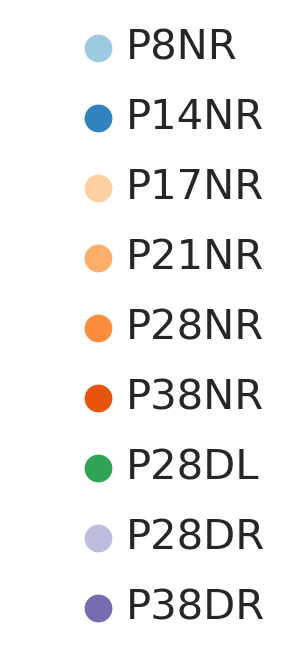

In [12]:
fig, ax = plt.subplots(figsize=(1,4))
for i, (key, item) in enumerate(palette.items()):
    ax.plot(0,     len(palette)-i, 'o', c=item, )
    ax.text(0.02,  len(palette)-i, key, va='center', fontsize=15)
    ax.axis('off')
plt.show()

# heatmap

# give each cell a pseudo-time index

In [13]:
ncell, ngene = zlognorm.shape

my_colors = ('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = ('C0', 'C1', 'C2', 'C3')
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

In [14]:
# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx = np.argsort(gpt)

In [15]:
# Use ptime from each sample analysis
dfall = []
for case in cases:
    f = f'../../results/cell_ptime_{case}_L23_Mar28.tsv'
    df = pd.read_csv(f, index_col=0)
    df['case'] = case
    dfall.append(df)
dfall = pd.concat(dfall)
assert np.all(dfall.index.values == adata.obs.index.values)
dfall

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC47,PC48,PC49,PC50,type,samp,umap1,umap2,ptime,case
AAACGCTCACTTCATT-1-P8_1a-P8,-4.167515,0.169273,2.574383,-1.589666,2.923386,-0.120249,-1.950705,-1.732618,-1.321194,0.659689,...,0.554465,-0.936461,0.380486,-0.015368,L2/3_AB,P8_1a,10.371646,3.036468,0.276353,P8NR
AAAGGATAGGTGCATG-1-P8_1a-P8,-5.710969,2.632143,-3.127635,2.985007,0.406603,-0.940489,0.612224,2.176416,-0.839287,3.160024,...,0.050299,-1.374758,-1.108813,-0.809501,L2/3_AB,P8_1a,11.195108,2.691917,0.170780,P8NR
AAAGGGCCAGTATACC-1-P8_1a-P8,0.363032,-1.037412,-2.000788,-1.303415,0.173461,-1.057998,-0.028259,-0.368191,0.805563,0.139518,...,-0.068263,-0.248844,-0.860799,0.422525,L2/3_AB,P8_1a,7.659028,1.148404,0.426782,P8NR
AAAGTCCCATATACCG-1-P8_1a-P8,0.603333,-1.386780,-2.359930,-2.483881,0.671093,0.319811,3.409799,-0.692306,0.300376,-0.038912,...,-0.238657,-0.449361,0.308295,0.059158,L2/3_AB,P8_1a,7.774300,1.742997,0.425401,P8NR
AAAGTCCTCAGATGCT-1-P8_1a-P8,6.168784,3.406447,-1.801495,-2.772495,0.837046,-1.310614,-1.121606,1.146195,-1.539873,-2.078232,...,-3.319709,-1.509901,-1.380832,0.662135,L2/3_BC,P8_1a,4.717086,1.385406,0.625315,P8NR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,1.603376,2.800474,1.054118,-2.621499,1.496856,3.133421,-0.524684,1.361778,-0.675490,-1.652105,...,0.693891,0.494570,0.283097,-0.610193,L2/3_3,P38_dr_1a,7.627140,2.115497,0.545054,P38DR
TTTGGTTTCTGCCTGT-1-P38_dr_2b,-3.830772,7.694133,-0.449819,2.001263,1.363460,-3.604184,2.277025,2.689968,-1.778446,1.101287,...,0.812298,1.058447,0.135438,-0.950600,L2/3_3,P38_dr_2b,9.046733,0.693446,0.562204,P38DR
TTTGTTGCACCGGTCA-1-P38_dr_2a,-2.635137,4.027407,-1.084643,1.620008,-0.744443,-0.695006,0.090084,3.042968,-0.855017,-1.101044,...,-1.234141,0.170709,0.457045,0.846405,L2/3_3,P38_dr_2a,9.125484,1.713715,0.498568,P38DR
TTTGTTGGTGGCTAGA-1-P38_dr_2b,-1.907812,0.440405,-0.632879,0.026408,-1.893107,-2.452266,-0.529140,-0.347105,0.620726,0.776882,...,0.859818,0.117613,-0.129171,-0.410174,L2/3_2,P38_dr_2b,9.331425,3.539268,0.478478,P38DR


In [16]:
def plot(zlognorm, cellidx, geneidx, types, genes_grp, case, 
         vmax=3, vmin=-3,
         figsize=(12,6), xticklabels=1000, yticklabels=100, hratio=20, vratio=10):
    """
    """
    mosaic = ("B"+"A"*hratio+"\n")*vratio + "."+"C"*hratio
    # print(mosaic)
    fig, axdict = plt.subplot_mosaic(mosaic, figsize=figsize)
    fig.suptitle(case)
    ax = axdict['A']
    sns.heatmap(zlognorm[cellidx][:,geneidx].T,
                xticklabels=False,
                yticklabels=False,
                cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
                center=0,
                vmax=vmax,
                vmin=vmin,
                cmap='coolwarm',
                rasterized=True,
                ax=ax,
               )

    ax = axdict['C']
    sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
                xticklabels=xticklabels,
                yticklabels=False,
                cmap=cmap_d1,
                cbar_kws=dict(ticks=[0,1,2], shrink=2, aspect=5),
                rasterized=True,
                ax=ax, 
               )
    ax.set_xlabel('Cells')
    fig.axes[-1].set_yticklabels(['A','B','C'])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    ax = axdict['B']
    sns.heatmap(pd.factorize(genes_grp[geneidx], sort=True)[0].reshape(-1,1), 
                xticklabels=False,
                yticklabels=yticklabels,
                cmap=cmap_d1,
                cbar=False,
                rasterized=True,
                ax=ax, 
               )
    ax.set_ylabel('Genes')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    fig.subplots_adjust(hspace=0.4)
    return fig, axdict
    # fig.suptitle(sample)
    # powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v3.pdf'))
    # plt.show()

In [17]:
# a big table of everything
allcells = adata.obs.index.values
bigmat = []
bigtypes = []

ncases = []
for case in cases:
    # select cells
    adata_sub = adata[adata.obs['cond']==case]
    cells_sub = adata_sub.obs.index.values
    cellsidx_sub = basicu.get_index_from_array(allcells, cells_sub)
    
    dfall_sub = dfall.loc[cells_sub]
    zlognorm_sub = zlognorm[cellsidx_sub]
    
    # order cells
    cellidx = np.argsort(dfall_sub['ptime'].values)
    types   = adata_sub.obs['easitype'].values
    
    bigmat.append(zlognorm_sub[cellidx])
    bigtypes.append(types[cellidx])
    ncases.append(len(cellidx))
    
bigmat = np.vstack(bigmat)
bigtypes = np.hstack(bigtypes)
bigmat.shape

(41048, 286)

In [18]:
print(np.percentile(bigmat, [0,5,95,100]))
# sns.boxplot(np.ravel(bigmat))

[-4.38444328 -0.99344778  2.02159657 11.47321129]


[-4.38444328 -0.99344778  2.02159657 11.47321129]


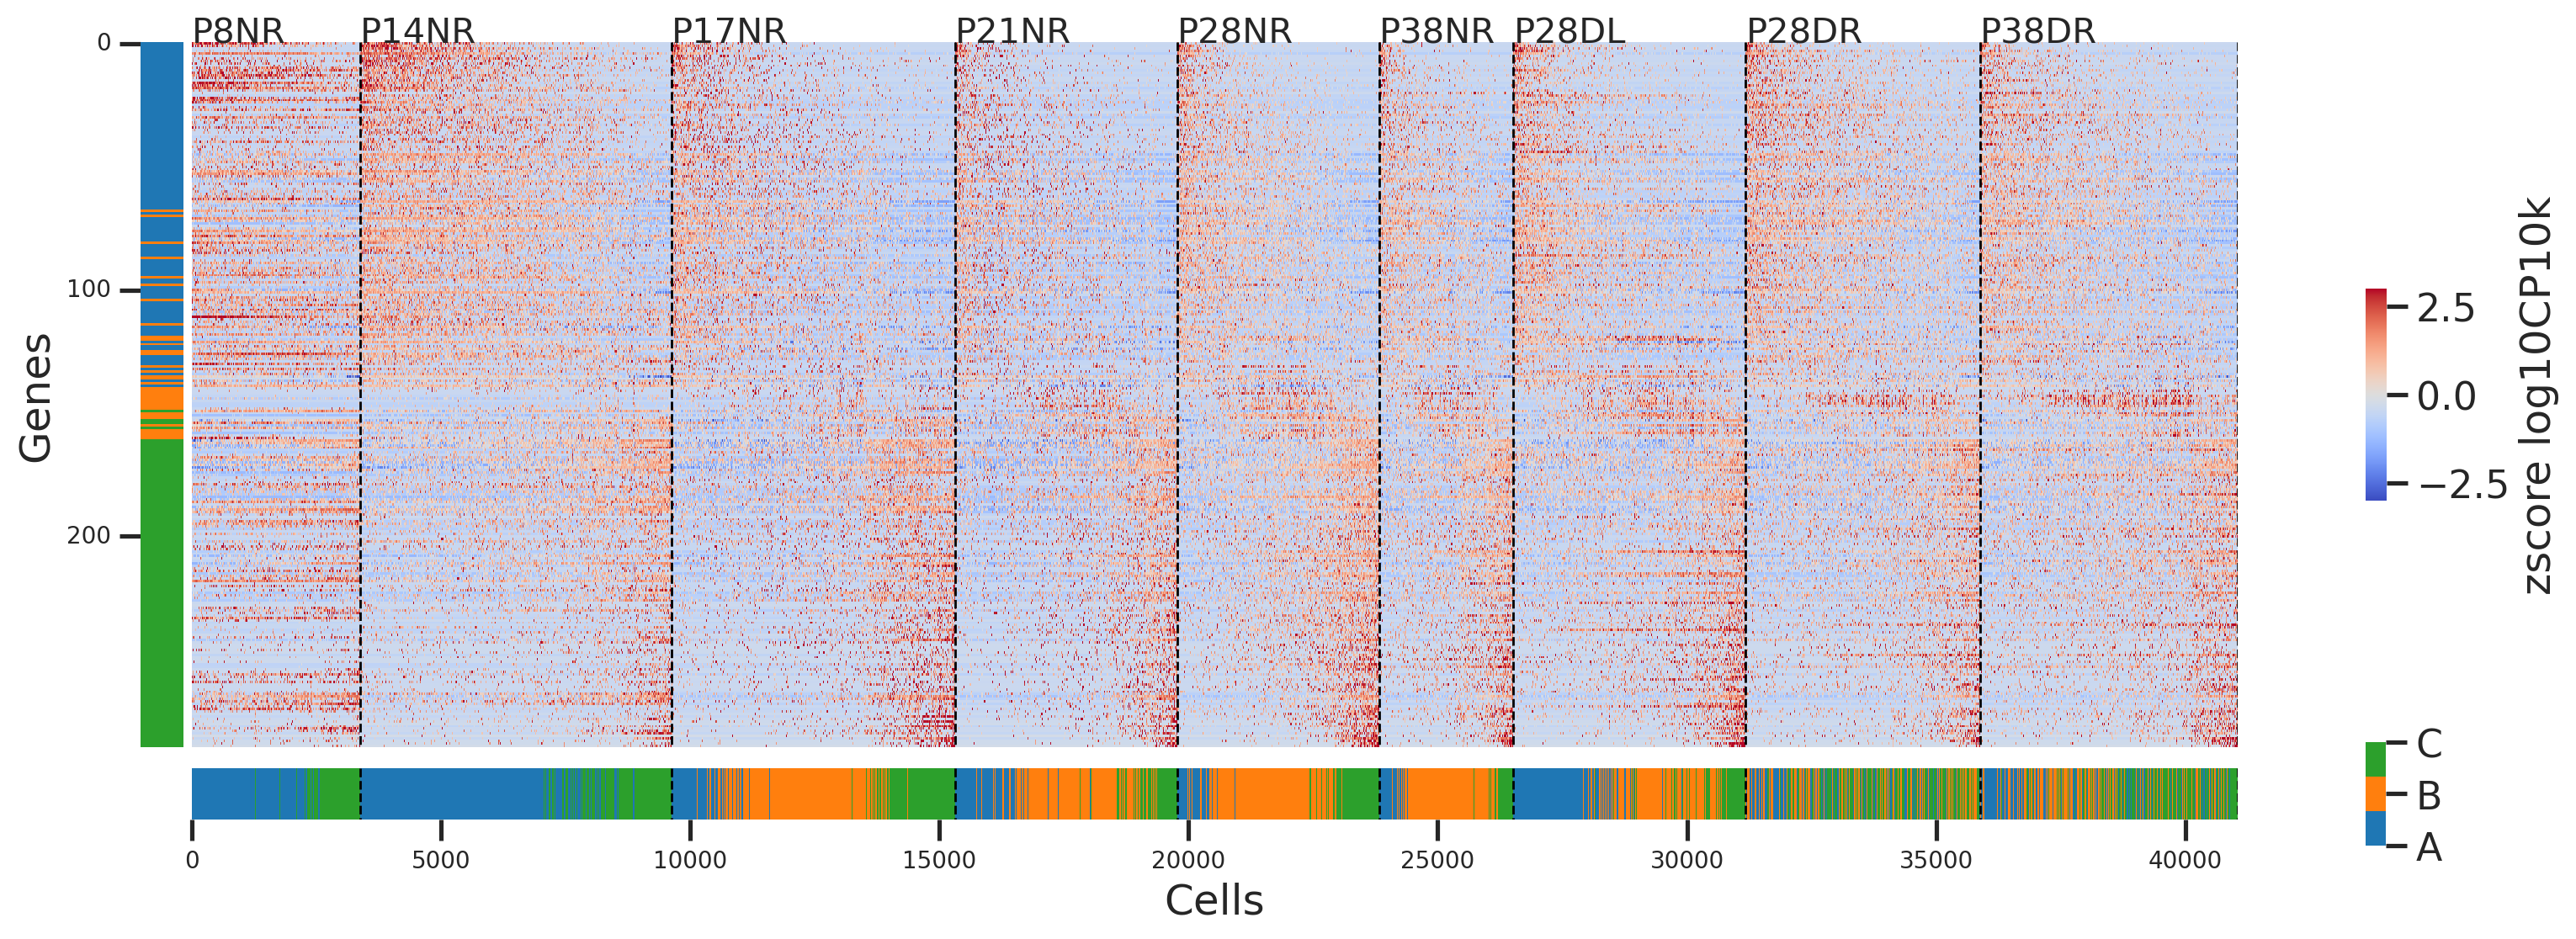

In [19]:
print(np.percentile(bigmat, [0,5,95,100]))

fig, axdict = plot(bigmat, np.arange(len(bigmat)), geneidx, bigtypes, genes_grp, "", 
                   figsize=(20,6), xticklabels=5000, hratio=50)
axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# Specific genes

In [20]:
genes_subsel = [
    'Cdh13', 
    'Adamts2', 
    
    'Trpc6', 
    'Baz1a', 
    
    'Chrm2', 
    'Grik3', 
]
genes_grp_subsel = np.array([
    'A', 'A', 
    'B', 'B',
    'C', 'C',
])
gidx_subsel = basicu.get_index_from_array(genes_sel, genes_subsel)
gidx_subsel


array([ 11,  10, 137, 149, 200, 167])

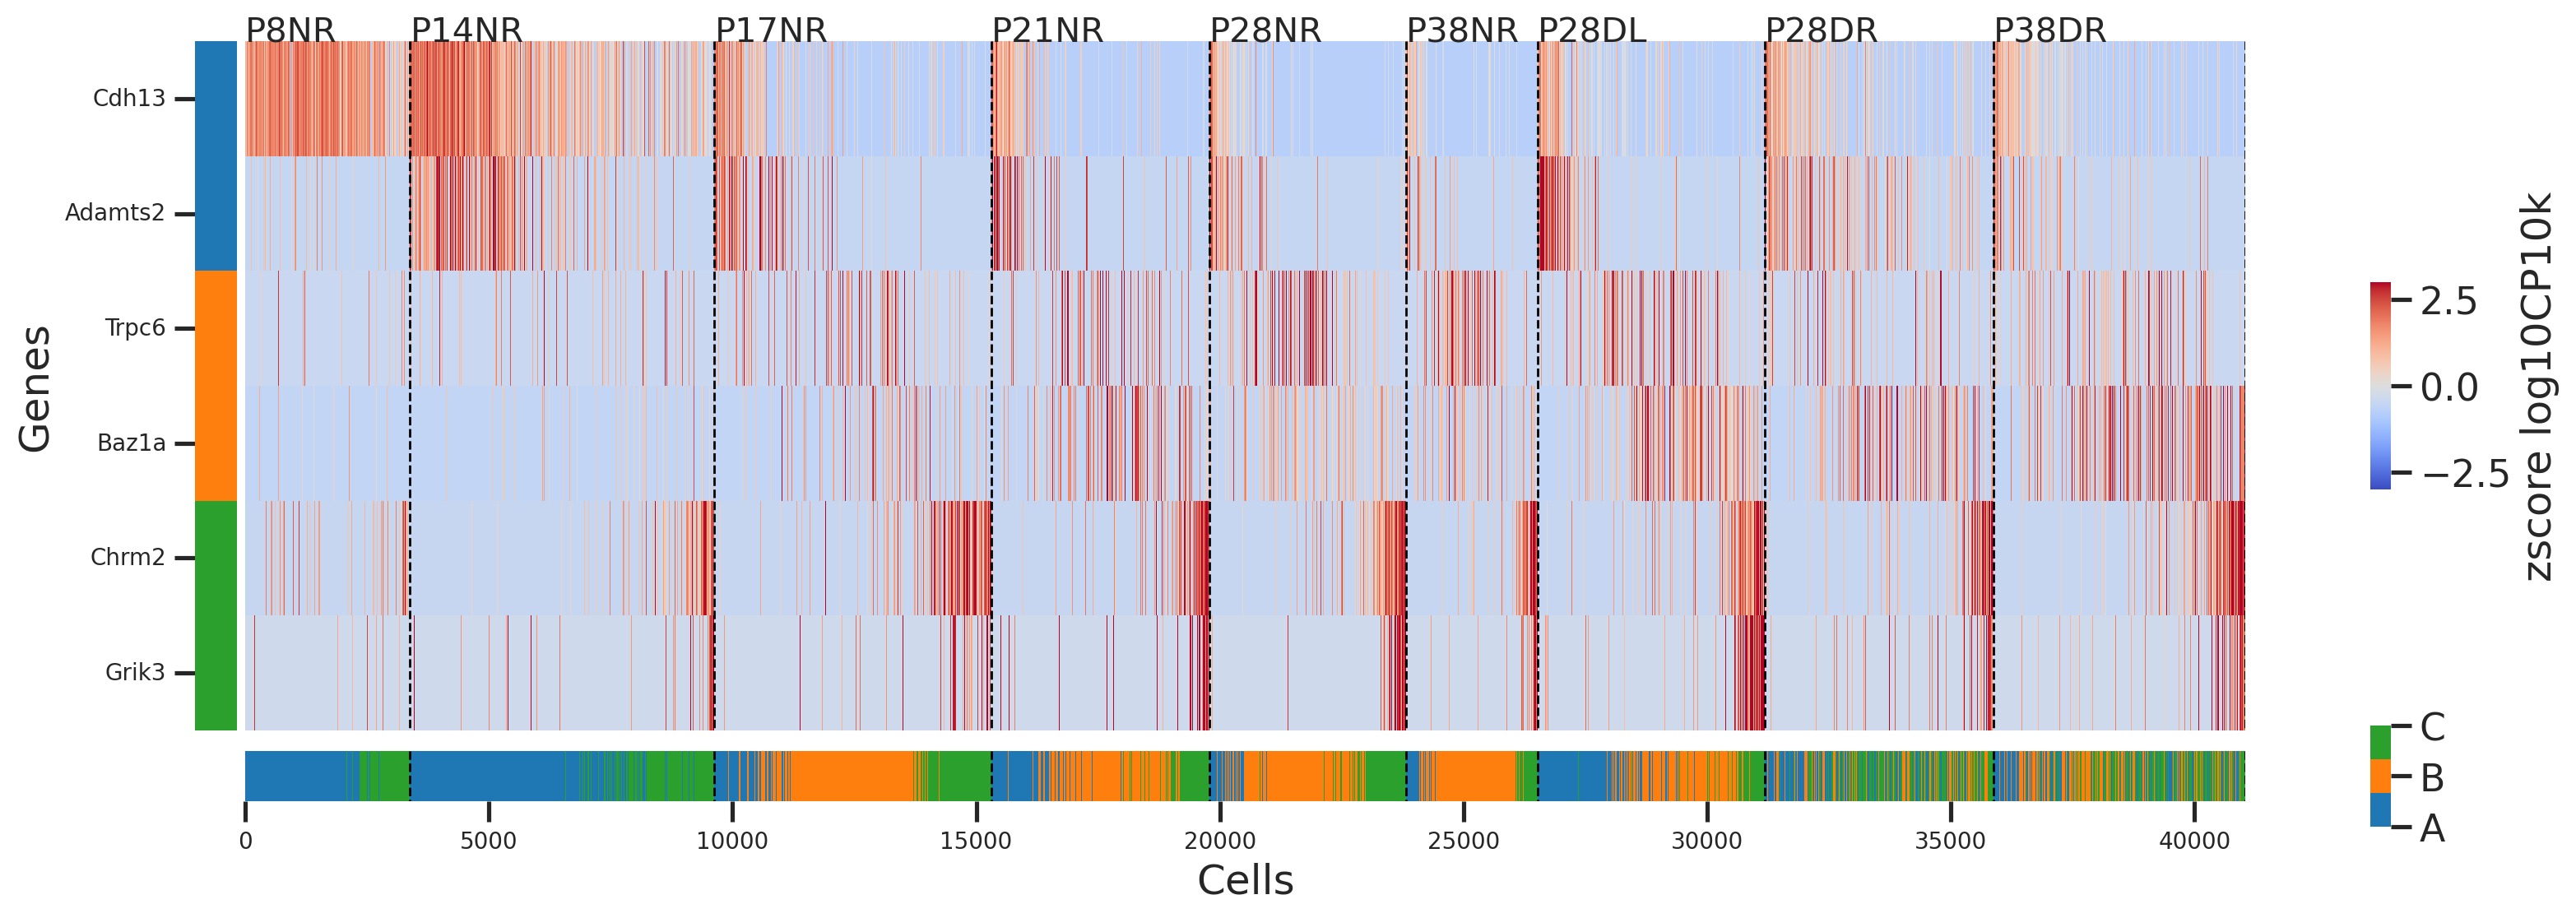

In [21]:
fig, axdict = plot(bigmat[:,gidx_subsel], np.arange(len(bigmat)), 
                   np.arange(len(genes_subsel)), bigtypes, genes_grp_subsel, "", 
                   figsize=(20,6), xticklabels=5000, yticklabels=genes_subsel, hratio=50)

axdict['A'].vlines(np.cumsum(ncases), 0, bigmat.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(ncases), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(ncases)]), cases):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# Collapse into types
- ordered by time and replicates

In [22]:
rename_cond = {
    'P8NR':  '1-P08NR', 
    'P14NR': '1-P14NR', 
    'P17NR': '1-P17NR', 
    'P21NR': '1-P21NR', 
    'P28NR': '1-P28NR', 
    'P38NR': '1-P38NR', 
    
    'P28DR': '2-P28DR', 
    'P38DR': '2-P38DR', 
    
    'P28DL': '3-P28DL',
}

adata.obs['easisample'] = adata.obs['sample'].apply(lambda x: x.split('_')[-1]) #.unique()
adata.obs['easicond']   = adata.obs['cond'].apply(lambda x: rename_cond[x]) #.unique()

In [23]:
groups = adata.obs['easicond'].astype(str) + "_" + adata.obs['easitype'].astype(str) + "_" + adata.obs['easisample'].astype(str)
print(groups.shape, counts.shape)
_clsts, _, _, logcpm = basicu.counts_to_bulk_profiles(counts, groups.values)
logcpm = logcpm[:,gi]
zlogcpm = zscore(logcpm, axis=0)

(41048,) (41048, 53801)


In [24]:
typesonly = pd.Series(_clsts).apply(lambda x: "_".join(x.split('_')[1:3])).values
condsonly = pd.Series(_clsts).apply(lambda x: x.split('_')[0]).values
unq, inv, cnts = np.unique(condsonly, return_counts=True, return_inverse=True)
unq, inv, cnts

(array(['1-P08NR', '1-P14NR', '1-P17NR', '1-P21NR', '1-P28NR', '1-P38NR',
        '2-P28DR', '2-P38DR', '3-P28DL'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8]),
 array([ 8,  8, 12, 12, 12,  9, 12, 12, 12]))

[-4.26490813 -1.66850305  1.56440126  3.4265158 ]


<Axes: >

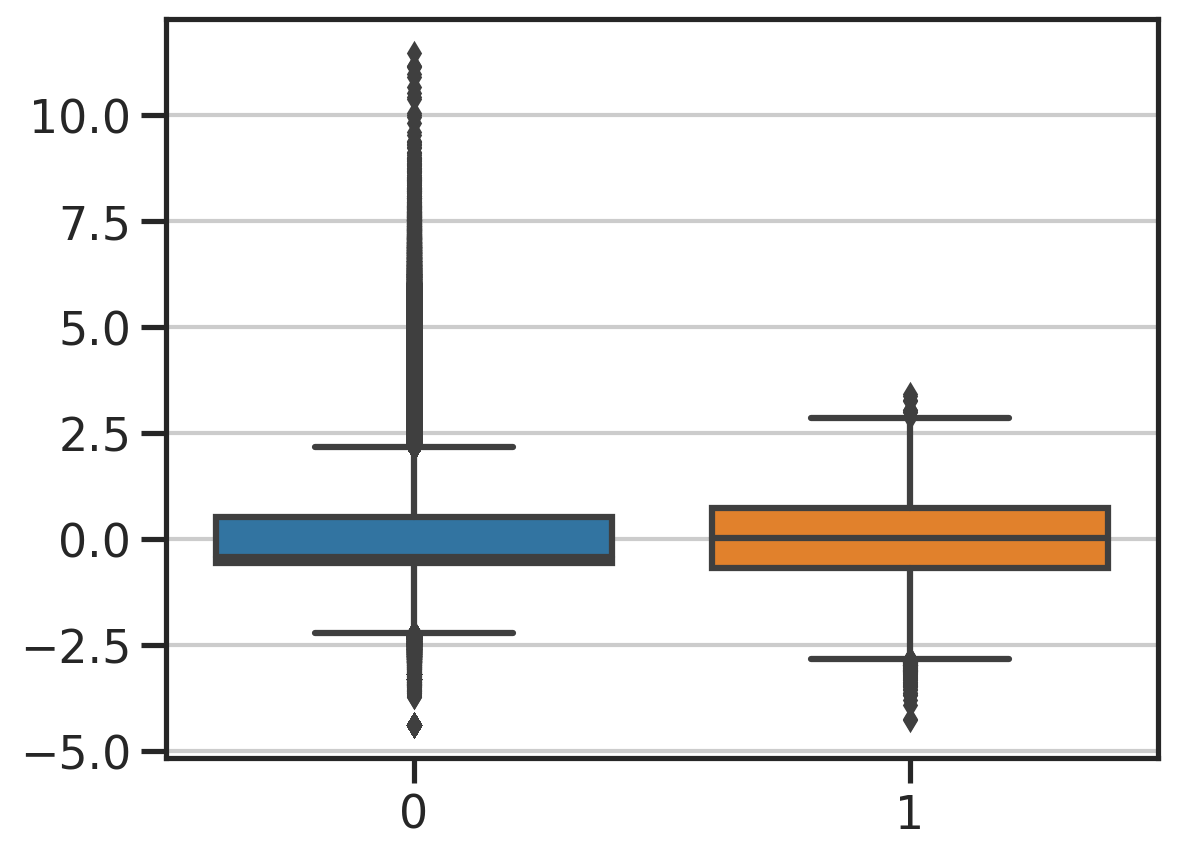

In [25]:
print(np.percentile(zlogcpm, [0,5,95,100]))
sns.boxplot([np.ravel(bigmat), np.ravel(zlogcpm)])

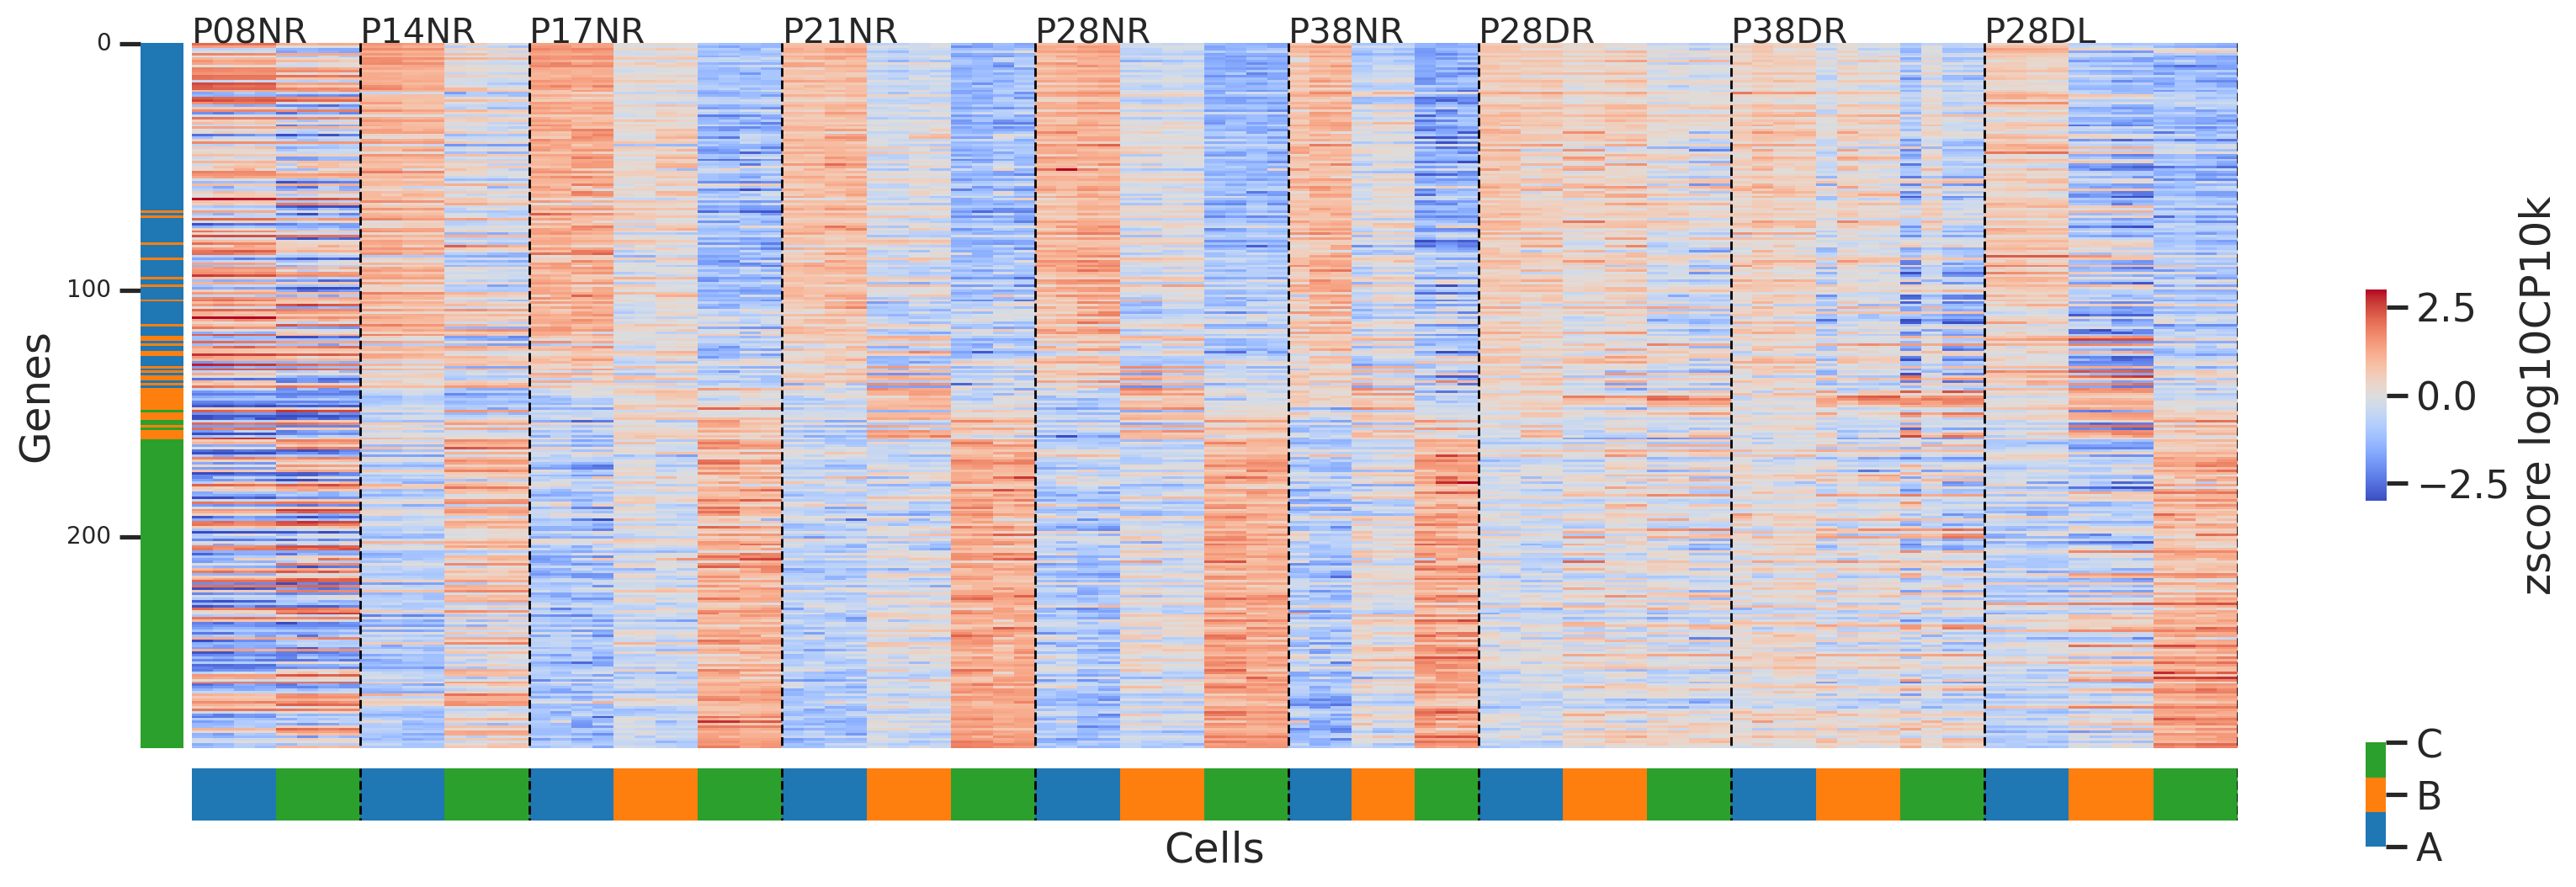

In [26]:
fig, axdict = plot(zlogcpm, np.arange(len(zlogcpm)), geneidx, typesonly, genes_grp, "", 
                   figsize=(20,6), xticklabels=False, hratio=50)

labels = pd.Series(unq).apply(lambda x: x.split('-')[1]).values
intvls = cnts

axdict['A'].vlines(np.cumsum(intvls), 0, zlogcpm.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(intvls), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(intvls)]), labels):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

# Collapse into new types
- recluster DR and DL using the 286 genes only

In [27]:
meta = adata.obs.copy()

In [28]:
meta['newtype'] = meta['easitype'].copy()
names = np.array(["L2/3_A","L2/3_B","L2/3_C"])

for case in ['P28DR', 'P38DR', 'P28DL', 'P28NR', 'P38NR']:
    adatasub = adata[adata.obs['cond']==case] #].str.contains('P28|P38')]
    ftrs = np.array(adatasub.layers['zlog10CP10k'])
    cells = adatasub.obs.index.values
    lbls = KMeans(n_clusters=3, n_init=10, random_state=0).fit_predict(ftrs)

    # figure out which is which
    mftrs, _ = basicu.group_mean(ftrs, lbls)
    ai = np.argmax(np.mean(mftrs[:,geneidx[:10]] , axis=1)) 
    ci = np.argmax(np.mean(mftrs[:,geneidx[-10:]], axis=1))
    bi = [i for i in [0,1,2] if i not in [ai, ci]][0]
    print(ai, bi, ci)
    names[ai] = 'L2/3_A'
    names[bi] = 'L2/3_B'
    names[ci] = 'L2/3_C'
    
    newtypes = names[lbls] # 
    meta.loc[cells, 'newtype'] = newtypes

2 1 0
2 1 0
2 0 1
2 1 0
1 0 2


In [29]:
groups = meta['easicond'].astype(str) + "_" + meta['newtype'].astype(str) + "_" + meta['easisample'].astype(str)
print(groups.shape, counts.shape)
_clsts, _, _, logcpm = basicu.counts_to_bulk_profiles(counts, groups.values)
logcpm = logcpm[:,gi]
zlogcpm = zscore(logcpm, axis=0)

(41048,) (41048, 53801)


In [30]:
typesonly = pd.Series(_clsts).apply(lambda x: "_".join(x.split('_')[1:3])).values
condsonly = pd.Series(_clsts).apply(lambda x: x.split('_')[0]).values
unq, inv, cnts = np.unique(condsonly, return_counts=True, return_inverse=True)
unq, inv, cnts

(array(['1-P08NR', '1-P14NR', '1-P17NR', '1-P21NR', '1-P28NR', '1-P38NR',
        '2-P28DR', '2-P38DR', '3-P28DL'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8]),
 array([ 8,  8, 12, 12, 12,  9, 12, 12, 12]))

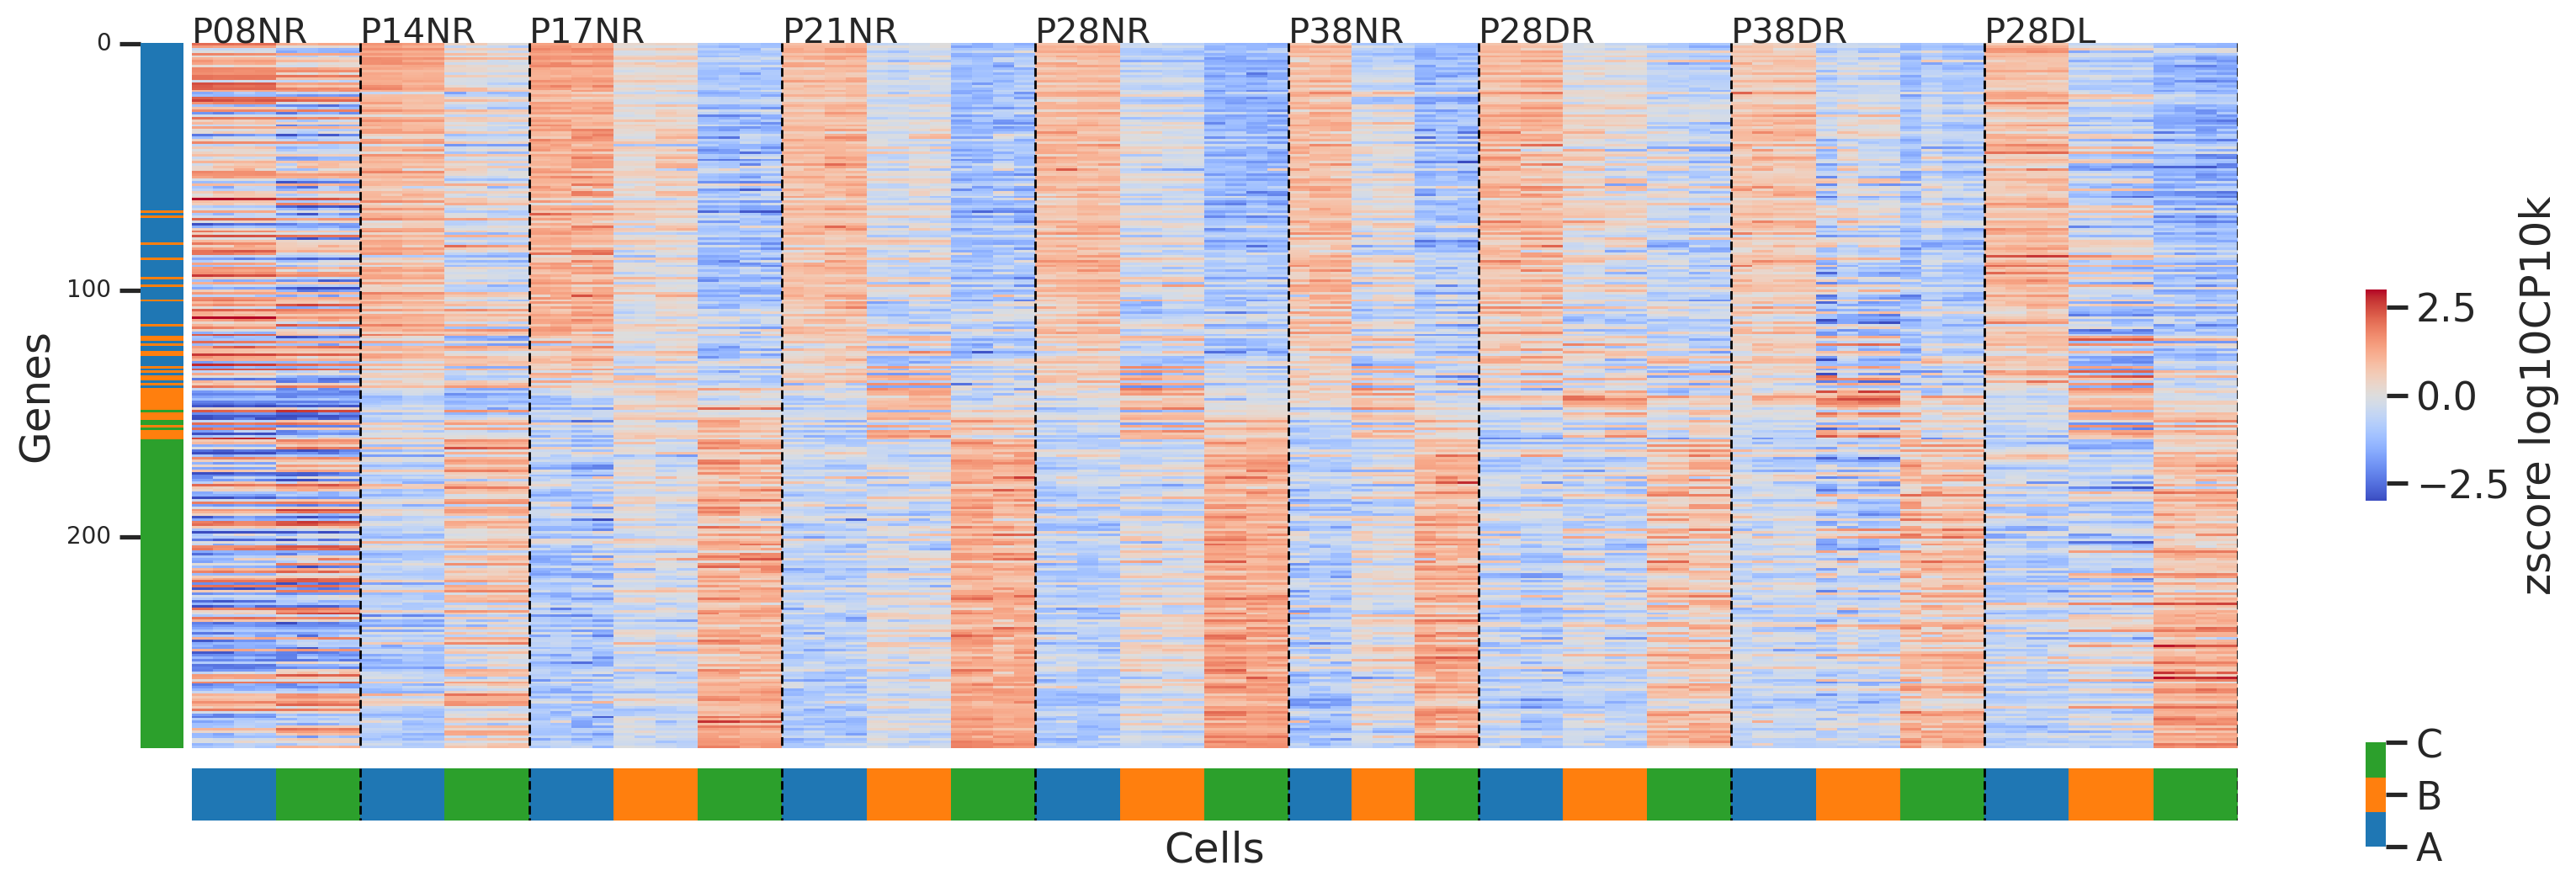

In [31]:
fig, axdict = plot(zlogcpm, np.arange(len(zlogcpm)), geneidx, typesonly, genes_grp, "", 
                   figsize=(20,6), xticklabels=False, hratio=50)

labels = pd.Series(unq).apply(lambda x: x.split('-')[1]).values
intvls = cnts

axdict['A'].vlines(np.cumsum(intvls), 0, zlogcpm.shape[1], color='k', linestyle='--', linewidth=1)
axdict['C'].vlines(np.cumsum(intvls), 0, 1, color='k', linestyle='--', linewidth=1)
for x, case in zip(np.hstack([[0], np.cumsum(intvls)]), labels):
    axdict['A'].text(x, 0, case, fontsize=15)
plt.show()

In [32]:
meta

,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [34]:
# fout = os.path.join(outdir, "allL23_newtypes.csv")
# meta.to_csv(fout, header=True, index=True)

# Quantify this